Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet 

In [0]:
#%reload_ext autoreload        <------------— comment out 
#%autoreload 0                 <------------— comment out
%matplotlib inline

In [7]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmpu0m5r2xo/pubring.gpg' created
gpg: /tmp/tmpu0m5r2xo/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [9]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

KeyboardInterrupt: ignored

In [5]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

In [10]:
! ls

datalab  log	ngrok-stable-linux-amd64.zip	ngrok-stable-linux-amd64.zip.2
drive	 ngrok	ngrok-stable-linux-amd64.zip.1	ngrok-stable-linux-amd64.zip.3


In [0]:
# to load files from Colab env to Google Drive

!pip install -U -q PyDrive

import tensorflow as tf
import timeit

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Enable Tensorboard

In [10]:
!pip install tensorboardX

In [47]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2018-07-28 15:17:45--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.44.230.61, 52.203.53.176, 52.44.144.199, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.44.230.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.3’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2018-07-28 15:17:45 (43.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.3’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

## Run ngrok

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

## Get URL
Run the next cell to start the training before open the url.

In [13]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://41fcd129.ngrok.io



Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
plt.rcParams['axes.grid'] = False
plt.rcParams['image.interpolation'] = 'nearest'
# mpl.rcParams['figure.figsize'] = 15, 25

In [0]:
N_EPOCHS = 25

In [0]:
DATA_FOLDER = "drive/Colab Notebooks/transfer learning/"

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [37]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 5.5MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /content/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Scale((224, 224)),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
#             iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-20, 20), mode='symmetric'),
            iaa.Sometimes(0.25,
                          iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                     iaa.CoarseDropout(0.1, size_percent=0.5)])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])
      
    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
#         ImgAugTransform(),
#         transforms.RandomRotation(20),
#         transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = DATA_FOLDER+'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images  
Let's visualize a few training images so as to understand the data
augmentations.



In [43]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL

  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
# def show_dataset(dataset, n=6):
#     imgs = torch.stack([dataset[i][0] for _ in range(n)
#                        for i in range(len(dataset))])
#     grid = torchvision.utils.make_grid(imgs).numpy()
#     plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
#     plt.axis('off')
    
# show_dataset(inputs)

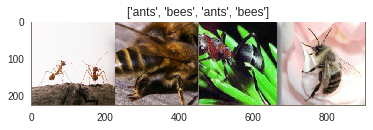

In [43]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
#             n_data = len(dataloaders[phase])
#             i = 0
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                #show input image on tensorboard
#                 writer.add_image(phase+"input_images", inputs)
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # view on tensorboard
            writer.add_scalar(phase +"_loss", (epoch_loss), epoch)
            writer.add_scalar(phase +"_acc", (epoch_acc), epoch)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualizing the model predictions

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the resnet convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [0]:
save_logs_path = "./log/pretrained-resnet-augm-2"
writer = SummaryWriter(save_logs_path)

In [38]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=N_EPOCHS) 

Epoch 0/24
----------
train Loss: 0.2978 Acc: 0.8852
val Loss: 0.2666 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4413 Acc: 0.7869
val Loss: 0.3001 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.3134 Acc: 0.8852
val Loss: 0.2722 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3549 Acc: 0.8361
val Loss: 0.2609 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3852 Acc: 0.8197
val Loss: 0.2757 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.3844 Acc: 0.8361
val Loss: 0.2655 Acc: 0.9020

Epoch 6/24
----------
train Loss: 0.3924 Acc: 0.8402
val Loss: 0.2717 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.3729 Acc: 0.8361
val Loss: 0.2696 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3258 Acc: 0.8525
val Loss: 0.3009 Acc: 0.8562

Epoch 9/24
----------
train Loss: 0.3567 Acc: 0.8361
val Loss: 0.2944 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2850 Acc: 0.8811
val Loss: 0.2761 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.3298 Acc: 0.8443
val Loss: 0.2658 Acc: 0.8889

Ep

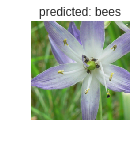

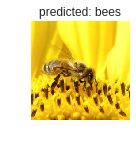

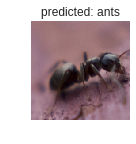

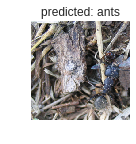

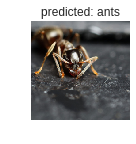

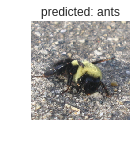

In [39]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.inception_v3(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
save_logs_path = "./log/freezed-inception"
writer = SummaryWriter(save_logs_path)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=N_EPOCHS)

Epoch 0/24
----------
train Loss: 0.8408 Acc: 0.6352


Process Process-1043:
Process Process-1042:
Process Process-1041:
Process Process-1044:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-

KeyboardInterrupt: ignored

In [0]:
!rm -rf log/pretrained-resnet-more-augm_with_flip

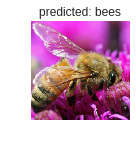

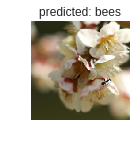

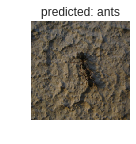

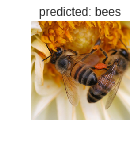

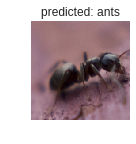

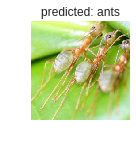

In [47]:
visualize_model(model_conv)

plt.ioff()
plt.show()